In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
import ds_functions as ds

from io import StringIO
from IPython.display import Image, display
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
def decision_tree_analysis(X, y, n_holdouts=10):
    min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
    max_depths = [2, 5, 10, 15, 20, 25]
    criteria = ['entropy', 'gini']
    best = ('',  0, 0.0)
    last_best = 0
    best_tree = None

    n = 1

    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
    for k in range(len(criteria)):
        f = criteria[k]
        values = {}
        for d in max_depths:
            yvalues = []
            for imp in min_impurity_decrease:

                total_acc = 0

                # Computing the average accuracy for this combination of hyper-parameters
                for h in range(n_holdouts):
                    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                    tree = DecisionTreeClassifier(min_samples_leaf=n, max_depth=d, criterion=f, min_impurity_decrease=imp)
                    tree.fit(trnX, trnY)
                    prdY = tree.predict(tstX)
                    total_acc += metrics.accuracy_score(tstY, prdY)

                total_acc /= n_holdouts
                yvalues.append(metrics.accuracy_score(tstY, prdY))
                if yvalues[-1] > last_best:
                    best = (f, d, imp)
                    last_best = yvalues[-1]
                    best_tree = tree

            values[d] = yvalues
        ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                               xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)
        
    return best, best_tree

In [3]:
def pruning_tree_analysis(X, y, n_holdouts=10):
    min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
    max_depths = [2, 5, 10, 15, 20, 25]
    criteria = ['entropy', 'gini']
    ccp_alphas = [0, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030]
    best = ('',  0, 0.0, 0.0)
    last_best = 0
    best_tree = None

    n = 1

    n_holdouts = 10

    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
    for k in range(len(criteria)):
        f = criteria[k]
        values = {}
        for d in max_depths:
            yvalues = []
            for imp in min_impurity_decrease:

                total_acc = 0

                # Computing the average accuracy for this combination of hyper-parameters
                for ccp_alpha in ccp_alphas:

                    for n in range(n_holdouts):

                        trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                        tree = DecisionTreeClassifier(min_samples_leaf=1, max_depth=d, criterion=f, min_impurity_decrease=imp, ccp_alpha=ccp_alpha)
                        tree.fit(trnX, trnY)
                        prdY = tree.predict(tstX)
                        total_acc += metrics.accuracy_score(tstY, prdY)

                total_acc /= n_holdouts * len(ccp_alphas)
                yvalues.append(metrics.accuracy_score(tstY, prdY))
                if yvalues[-1] > last_best:
                    best = (f, d, imp, ccp_alpha)
                    last_best = yvalues[-1]
                    best_tree = tree

            values[d] = yvalues
        ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Pruned Decision Trees with %s criteria'%f,
                               xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)
        
    return best, best_tree

In [4]:
def eval_tree(best_tree, n_holdouts=10):
    # Compute Average Metrics for Best Random Forest vs. Best Extremely Random Trees

    acc = [0, 0]
    recall = [0, 0]
    specificity = [0, 0]
    precision = [0, 0]
    matrices = np.zeros((2, 2, n_holdouts))

    for h in range(n_holdouts):
        trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

        rf = DecisionTreeClassifier(min_samples_leaf=1, max_depth=best_tree[1], criterion=best_tree[0], min_impurity_decrease=best_tree[2])
        rf.fit(trnX, trnY)

        prd_trn = rf.predict(trnX)
        prd_tst = rf.predict(tstX)

        cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
        tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
        cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
        matrices[:,:,h] = cnf_mtx_tst
        tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

        acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
        acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)

        recall[0] += tp_trn / (tp_trn + fn_trn)
        recall[1] += tp_tst / (tp_tst + fn_tst)

        specificity[0] += tn_trn / (tn_trn + fp_trn)
        specificity[1] += tn_tst / (tn_tst + fp_tst)

        precision[0] += tp_trn / (tp_trn + fp_trn)
        precision[1] += tp_tst / (tp_tst + fp_tst)


    acc = np.divide(acc, n_holdouts)
    recall = np.divide(recall, n_holdouts)
    specificity = np.divide(specificity, n_holdouts)
    precision = np.divide(precision, n_holdouts)
    cnf_mtx_rt = np.mean(matrices, axis=2).astype('int64')

    evaluation_rt = {'Accuracy': acc,
                  'Recall': recall,
                  'Specificity': specificity,
                  'Precision': precision}
    
    return evaluation_rt, cnf_mtx_rt

In [5]:
def plot_tree(best_tree):
    dot_data = StringIO()
    export_graphviz(best_tree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))


 ORAL_chi


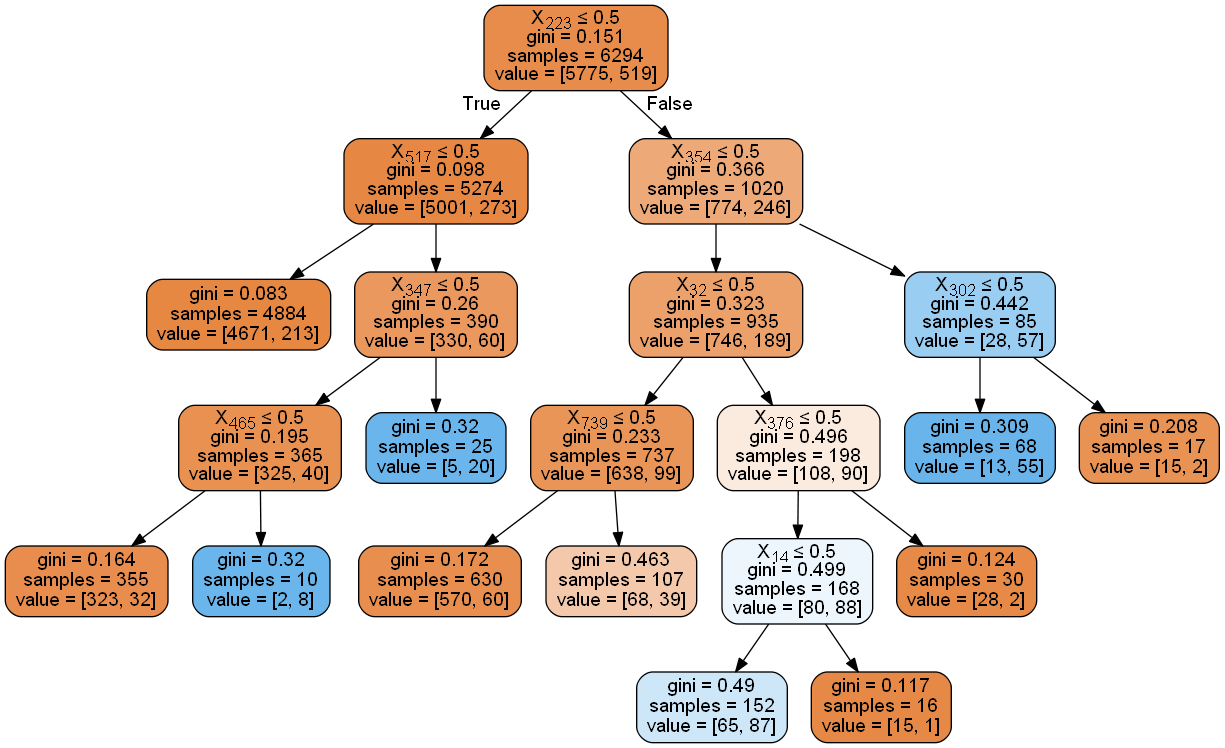

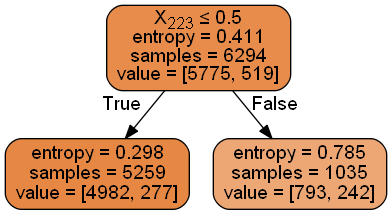

<Figure size 600x450 with 0 Axes>

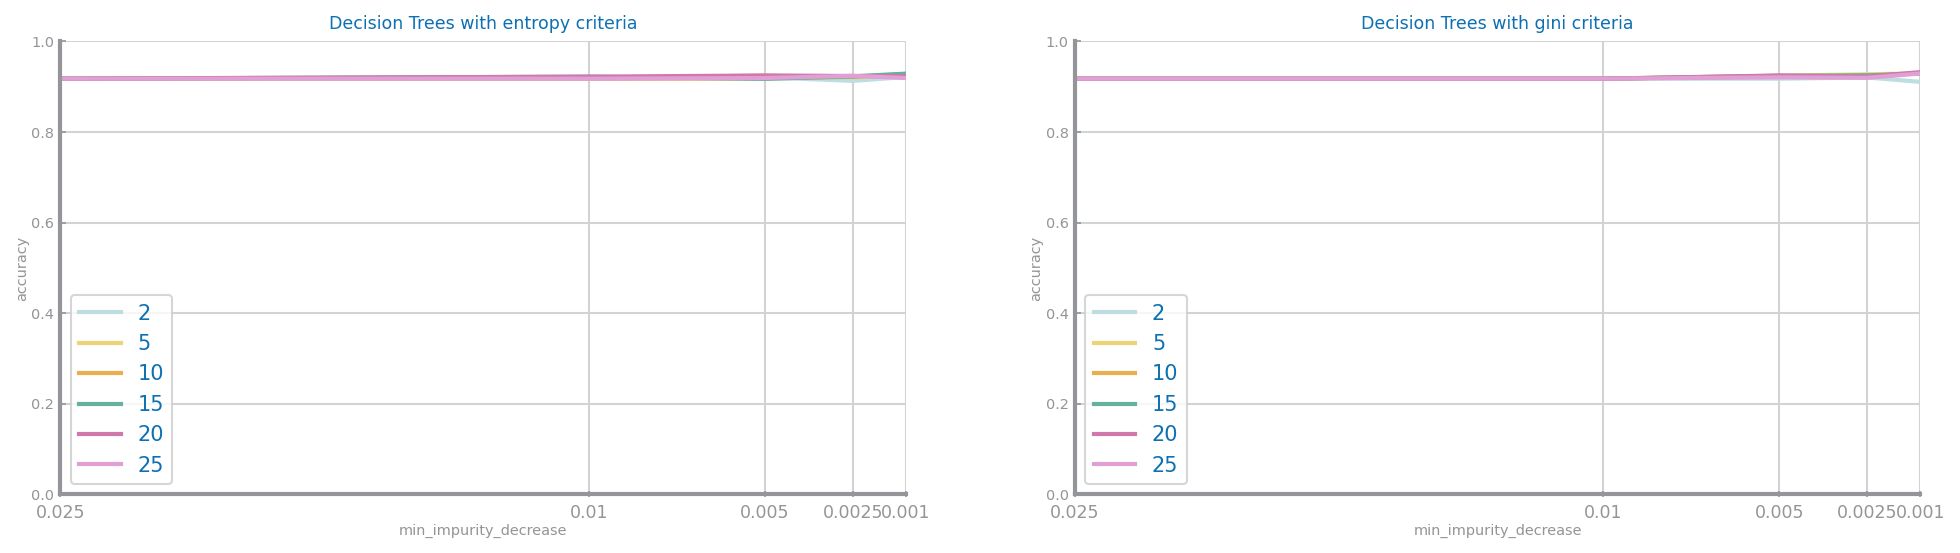

<Figure size 600x450 with 0 Axes>

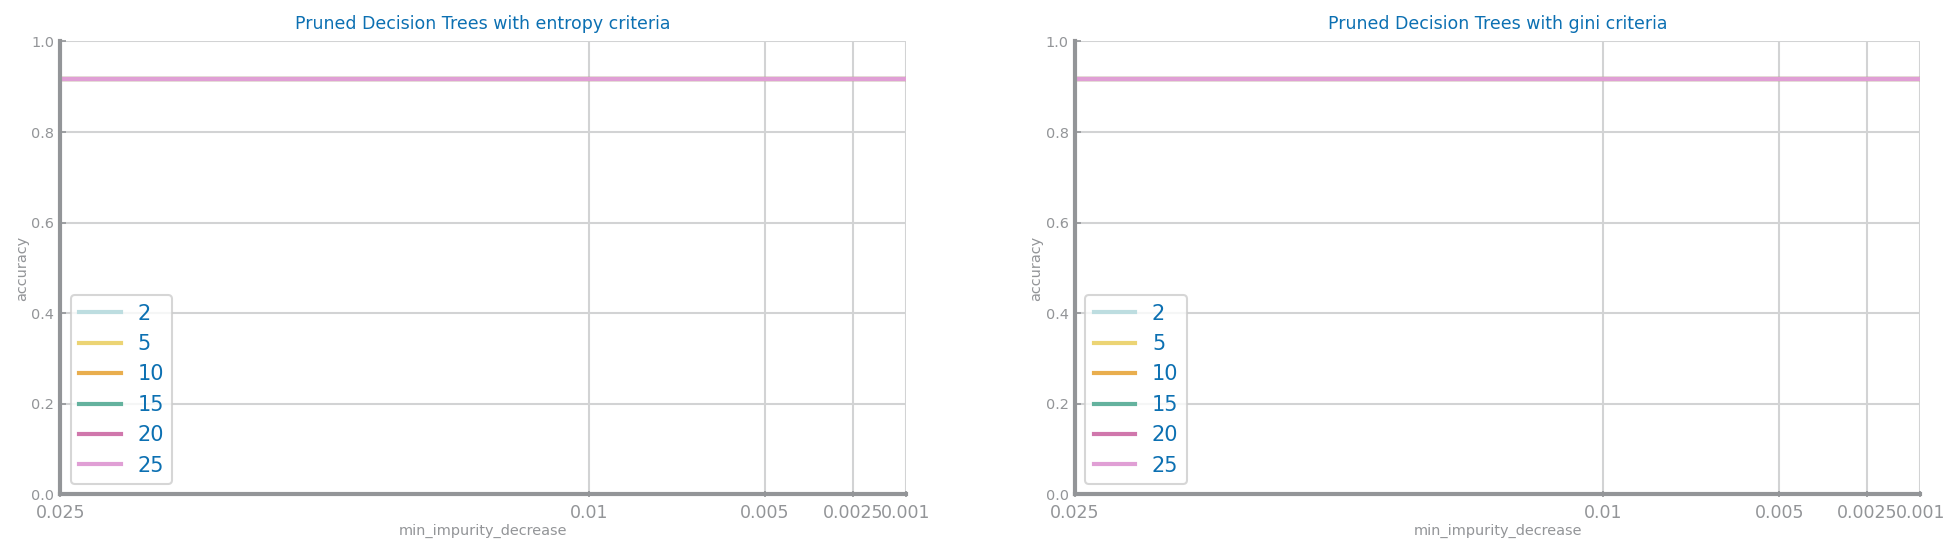

Decision Trees:
 {'Accuracy': array([0.93, 0.93]), 'Recall': array([0.34, 0.31]), 'Specificity': array([0.98, 0.98]), 'Precision': array([0.67, 0.62])}

Pruned DTrees:
 {'Accuracy': array([0.92, 0.92]), 'Recall': array([0., 0.]), 'Specificity': array([1., 1.]), 'Precision': array([nan, nan])}


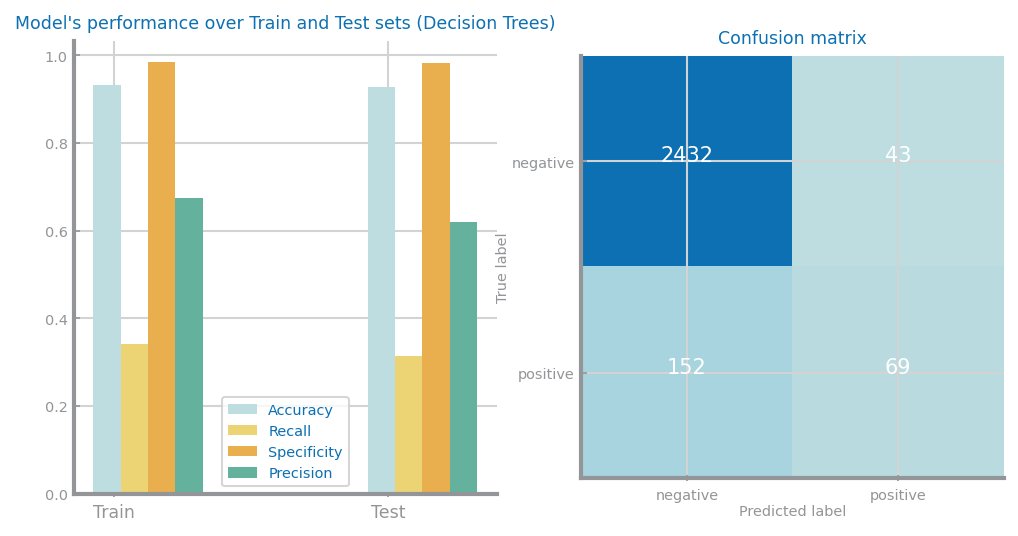

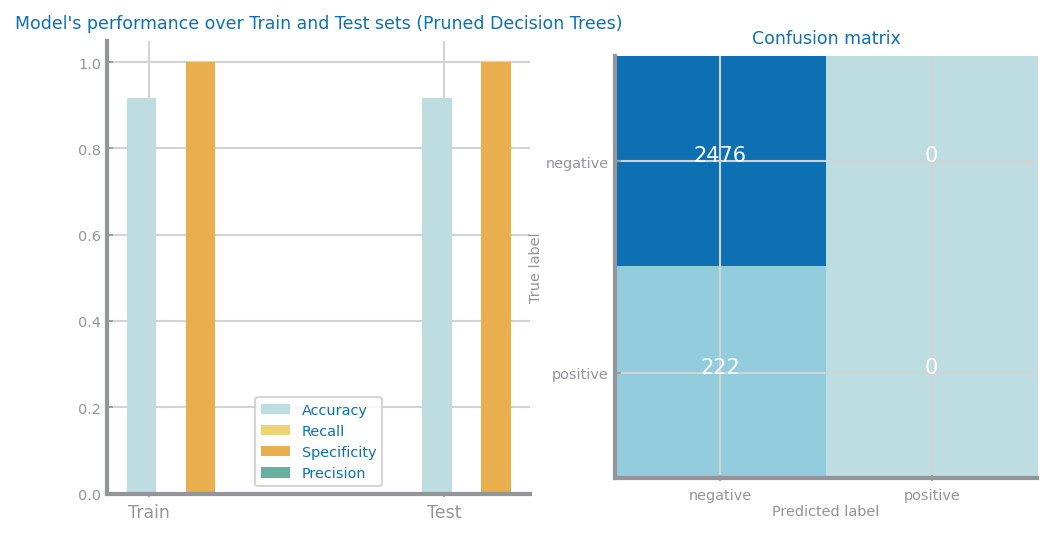








 ORAL_extraTreeClassifier


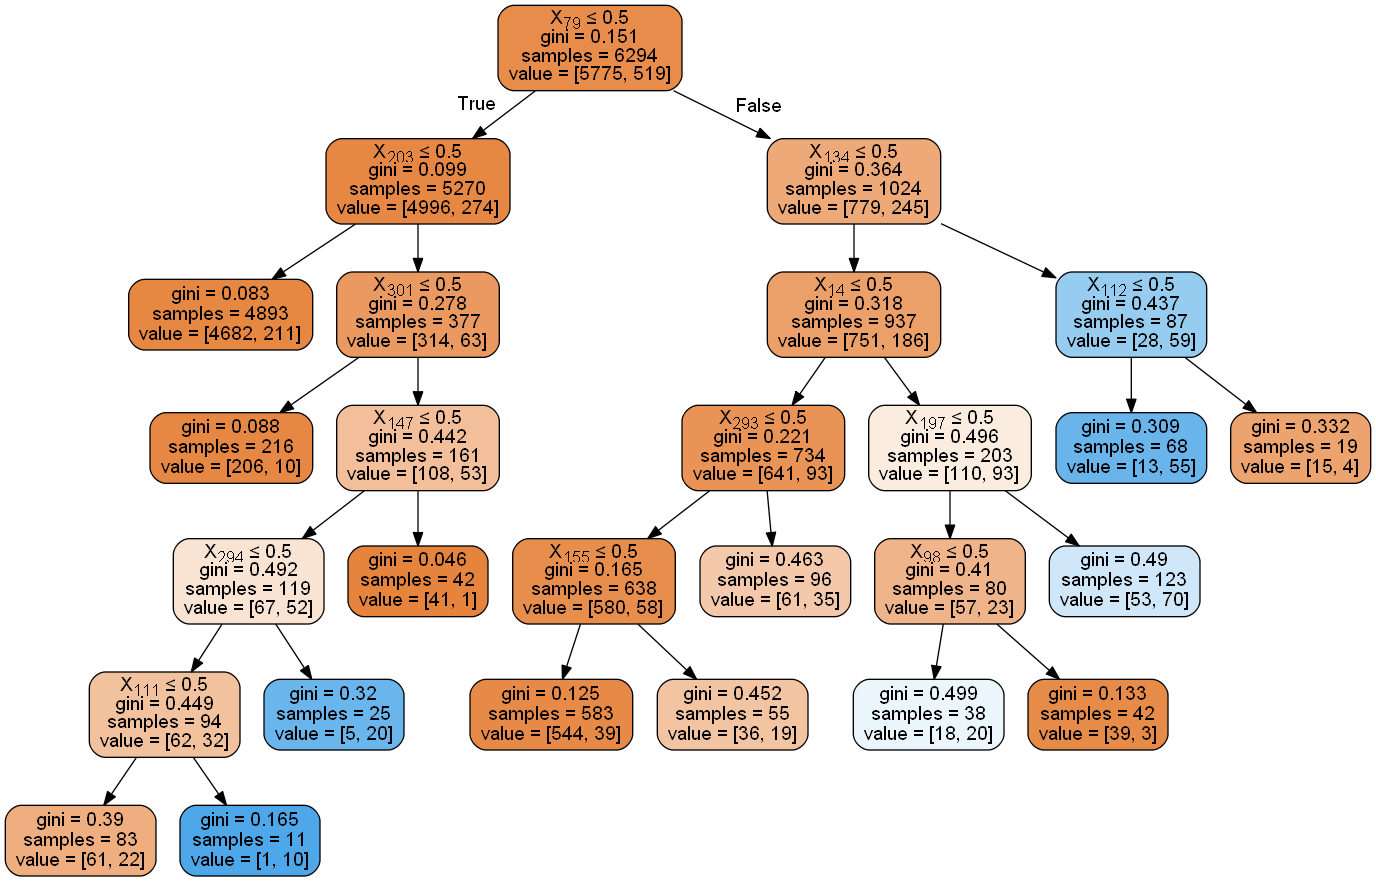

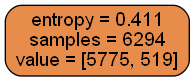

<Figure size 600x450 with 0 Axes>

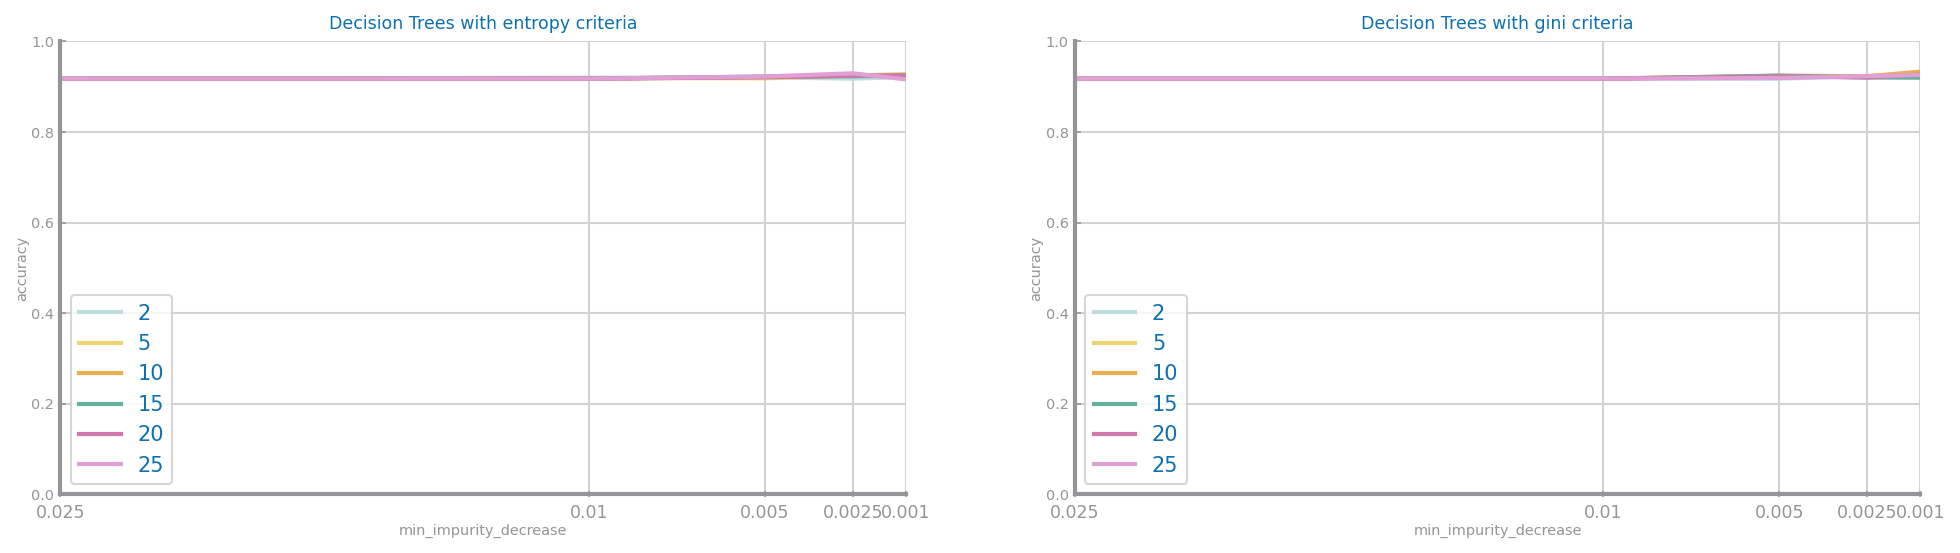

<Figure size 600x450 with 0 Axes>

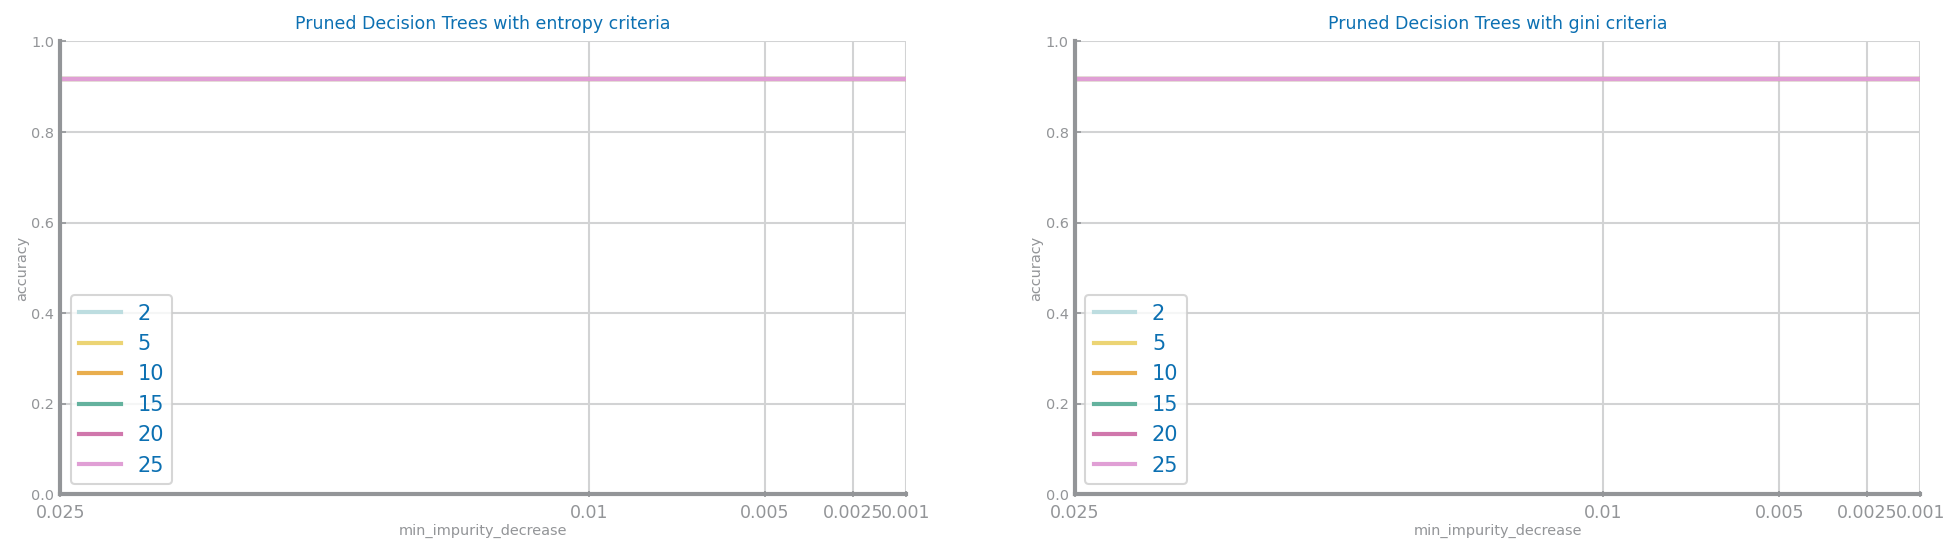

Decision Trees:
 {'Accuracy': array([0.93, 0.93]), 'Recall': array([0.3 , 0.27]), 'Specificity': array([0.99, 0.99]), 'Precision': array([0.69, 0.63])}

Pruned DTrees:
 {'Accuracy': array([0.92, 0.92]), 'Recall': array([0., 0.]), 'Specificity': array([1., 1.]), 'Precision': array([nan, nan])}


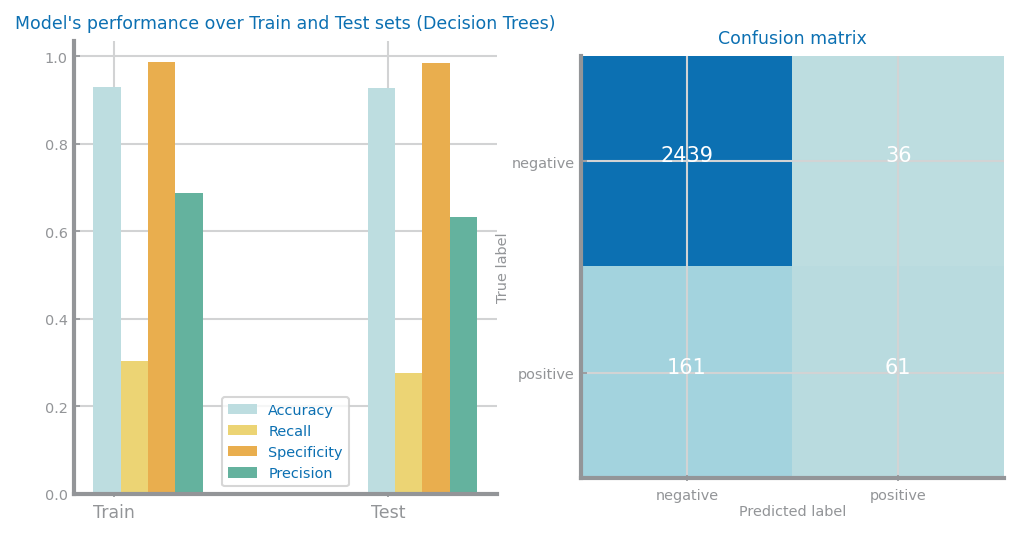

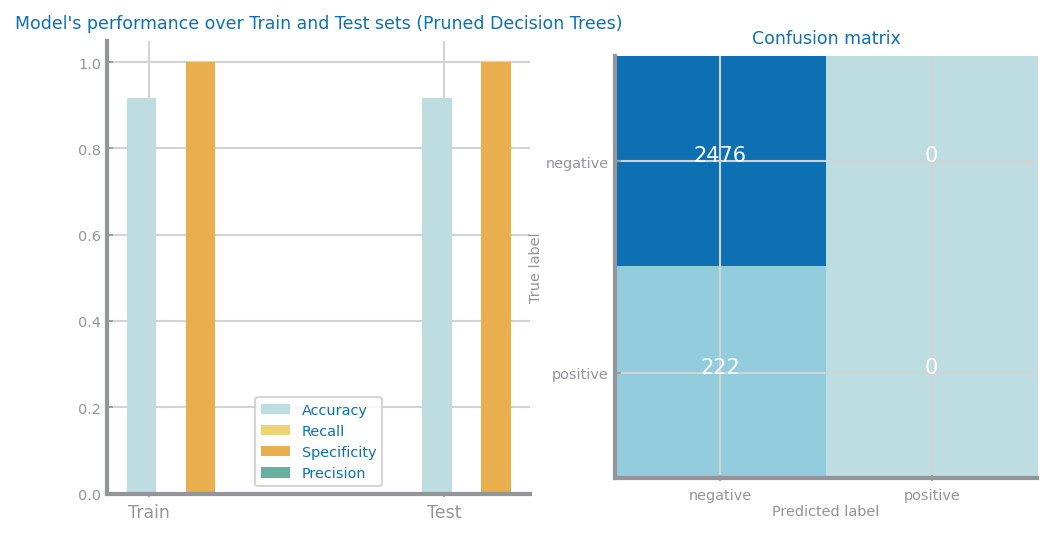








 ORAL_mutual


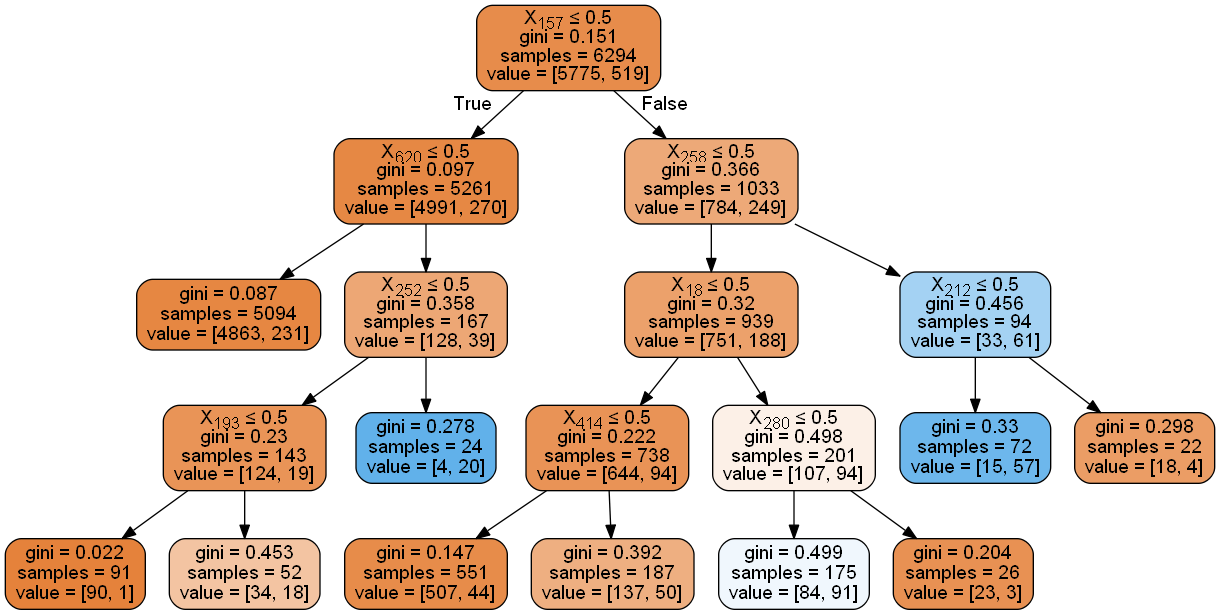

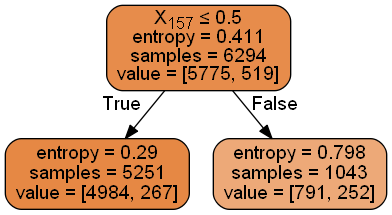

<Figure size 600x450 with 0 Axes>

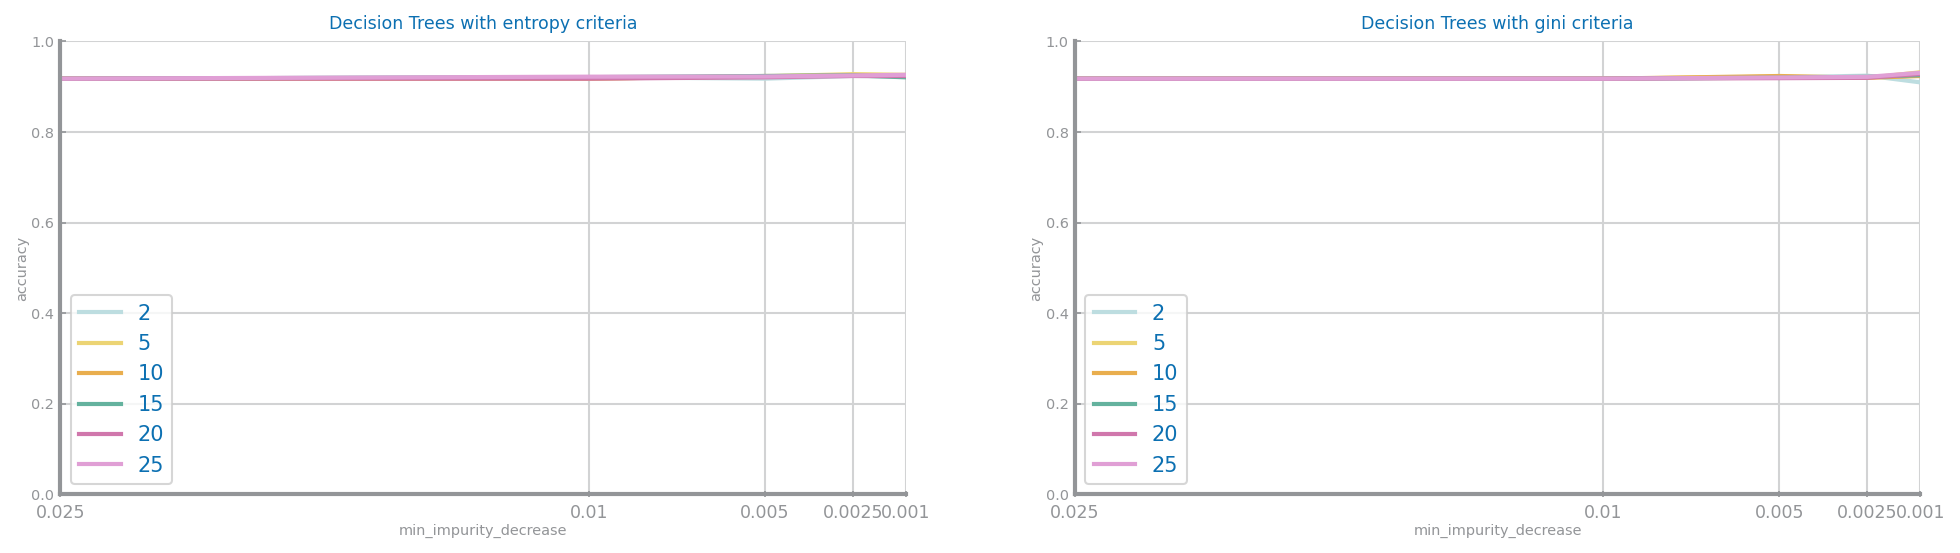

<Figure size 600x450 with 0 Axes>

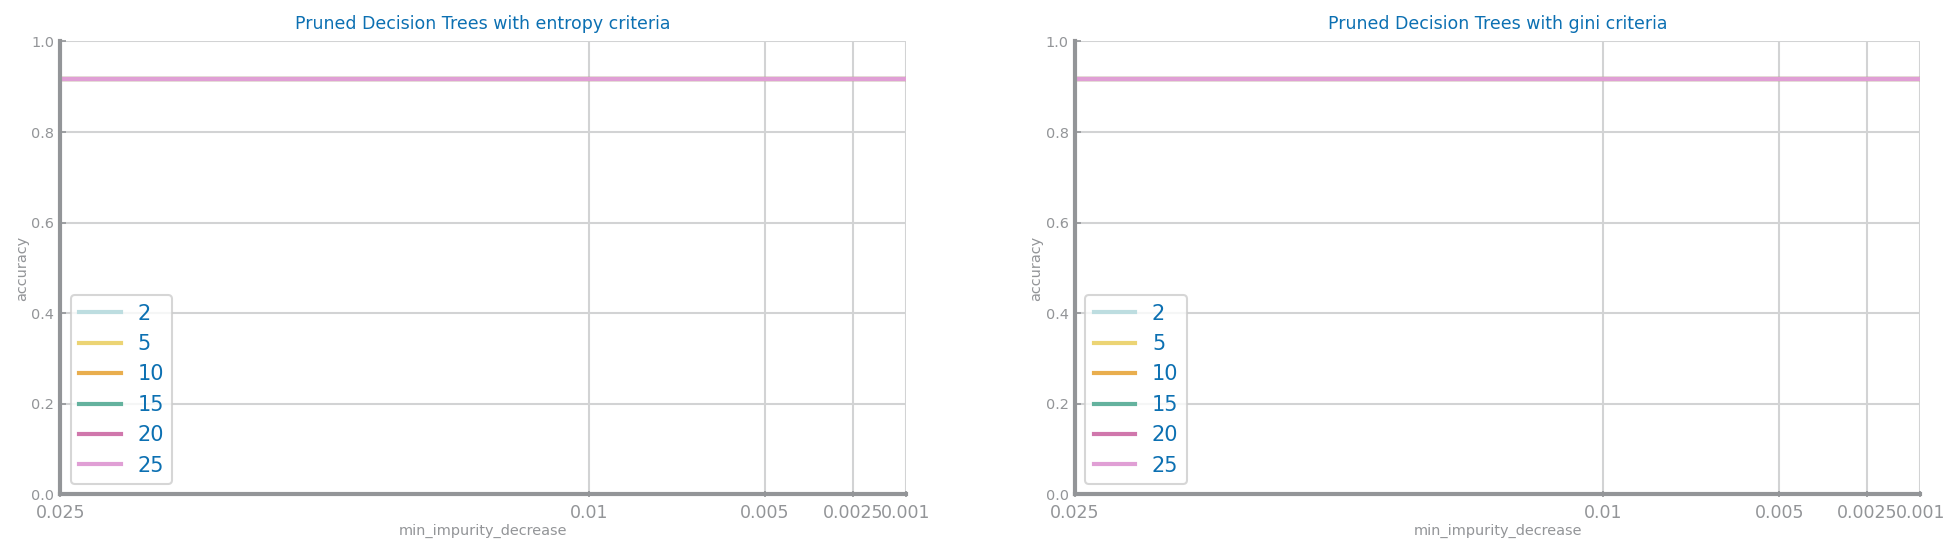

Decision Trees:
 {'Accuracy': array([0.93, 0.93]), 'Recall': array([0.32, 0.29]), 'Specificity': array([0.99, 0.98]), 'Precision': array([0.68, 0.63])}

Pruned DTrees:
 {'Accuracy': array([0.92, 0.92]), 'Recall': array([0., 0.]), 'Specificity': array([1., 1.]), 'Precision': array([nan, nan])}


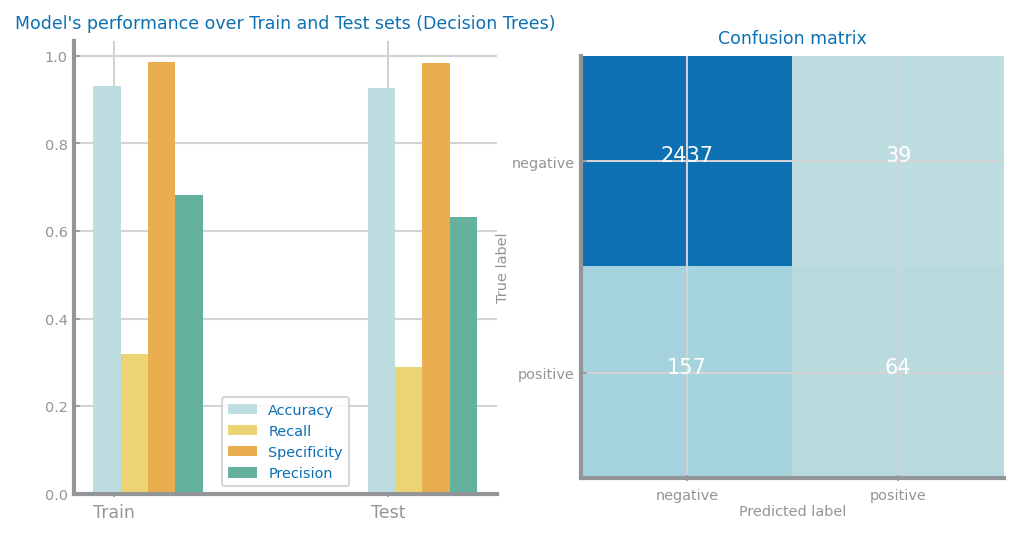

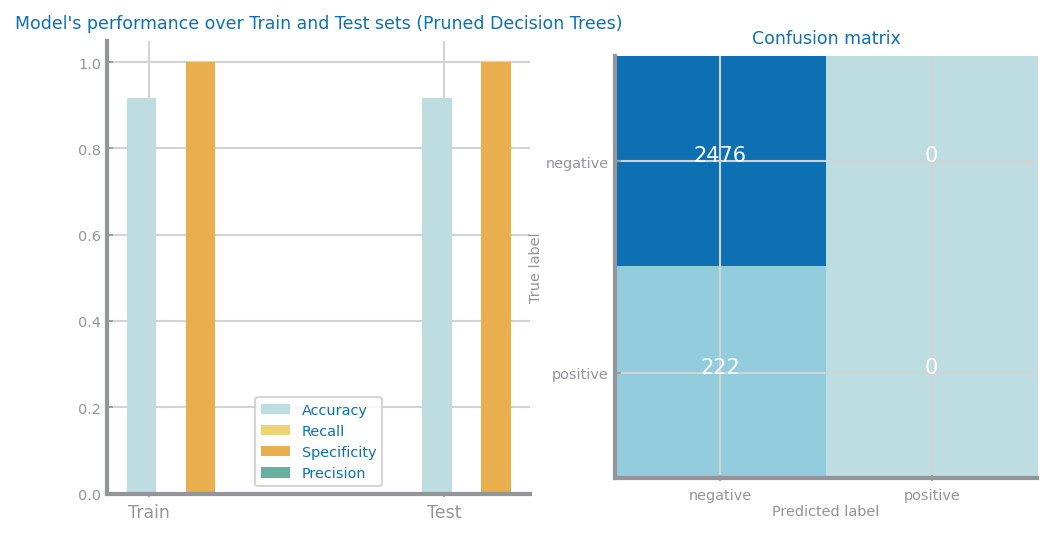








 ORAL_S_FChi_B


In [ ]:
import os

directory = '../../datasets/TO_TEST/ORAL'

overall_accs = []
datasets = []
    
for filename in os.listdir(directory):
    if filename.endswith(".csv"): 
        path = directory + '/' + filename
        print('\n', filename.split('.')[0])
        data: pd.DataFrame = pd.read_csv(path, sep=';', header=None)
        y: np.ndarray = data.iloc[:,-1:].values
        y: np.ndarray = np.array([x[0] for x in y])
        X: np.ndarray = data.iloc[:,:-1]
        labels = pd.unique(y)
            
        # Perform DTree analysis and display results
        best_tree, tree = decision_tree_analysis(X, y, n_holdouts=5)
        
        best_prune, prune = pruning_tree_analysis(X, y, n_holdouts=5)
        
        plot_tree(tree)

        plot_tree(prune)
        
        plt.show()


        
        # Evaluate the best random forest
        evaluation_rt, cnf_mtx_rt = eval_tree(best_tree)
        
        # Evaluate the best extremely random trees
        evaluation, cnf_mtx = eval_tree(best_prune)
        
        fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
        ds.multiple_bar_chart(['Train', 'Test'], evaluation_rt, ax=axs[0], title="Model's performance over Train and Test sets (Decision Trees)")
        ds.plot_confusion_matrix(cnf_mtx_rt, labels, ax=axs[1])

        print("Decision Trees:\n", evaluation_rt)

        fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
        ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets (Pruned Decision Trees)")
        ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

        print("\nPruned DTrees:\n", evaluation)
        
        plt.show()
        
        # Record the Maximum accuracy achieved
        max_acc = max(evaluation_rt['Accuracy'][1], evaluation['Accuracy'][1])
        overall_accs += [max_acc]
        
        # Dataset name
        datasets += [filename.split('.')[0]]

        
        print('\n\n\n\n\n')

In [ ]:
accs = pd.Series(overall_accs)
datasets = list(datasets)

res = {datasets[i]: overall_accs[i] for i in range(len(datasets))}

res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

accs = pd.Series(list(res.values()))

print(accs)

datasets = list(res.keys())
# Plot the figure.
plt.figure(figsize=(12, 8))
ax = accs.plot(kind='bar')
ax.set_title('Max Accuracy by Dataset (between the tested models)')
ax.set_xlabel('Dataset')
ax.set_ylabel('Accuracy')
ax.set_xticklabels(datasets)